# Recommender System with Book Rating Data

In this notebook, we focuses on visualizing the book rating data, as well as prepare the data for a recommender system based on collaborative filtering. This notebook is split into three parts:

**Section I:** explores the dataset to find interesting patterns <br />
**Section II:** prepare the dataset for collaborative filtering <br />
**Section III:** introduce and demonstrate collaborative filtering

### Section I:   
### Data Visualization and Exploratory Analysis

#### Load library
We start by loading some libraries

In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [112]:
import json
from pandas.io.json import json_normalize

#### Read data

We read three datafiles as dataframes. Where

*'BX-CSV-Dump/book-crossing_users.json'* has the user information <br />
*'BX-CSV-Dump/book-crossing_books.json'* has the book information <br />
*'BX-CSV-Dump/book-crossing_explicit_ratings.json'* has the users' ratings on books <br />

The describtions of the dataset can be found [Here](http://www2.informatik.uni-freiburg.de/~cziegler/BX/)

In [113]:
# Import Users file as dataframe
with open('BX-CSV-Dump/book-crossing_users.json') as data_file:
    data = data_file.readlines()
# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
User = pd.read_json(data_json_str)

In [114]:
# Import Books file as dataframe
with open('BX-CSV-Dump/book-crossing_books.json') as data_file:
        data = data_file.readlines()
# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
Books = pd.read_json(data_json_str)

In [115]:
# Import Ratings file as dataframe
# Note that duplicate entries of ratings have already been removed
# Also users who do not rate at least one book has been removed
# Books not receiving as least one review have been removed from rating matrix
# Only Explicit Ratings are loaded and analysed
with open('BX-CSV-Dump/book-crossing_explicit_ratings.json') as data_file:
        data = data_file.readlines()
# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
df = pd.read_json(data_json_str)

#### Have a look at the dataset

First, let's have a look at the dataset. Dataframe **df** contains users' ratings of books (a total of 383852 ratings, for 149842 books, from 68092 users). <br />

While dataframe **Books** contains more information on the books such as title, autor, year and publisher. 

The dataframe **User** has other user information, such as location and age <br />

Here we print out heads of ratings, Books, and User dataframe 

In [116]:
df.head()

,book_id,implicit,rating,user_id
0,0155061224,NaN,5,276726
1,052165615X,NaN,3,276729
2,0521795028,NaN,6,276729
3,038550120X,NaN,7,276744
4,0060517794,NaN,9,276747


In [117]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383852 entries, 0 to 383851
Data columns (total 4 columns):
book_id     383852 non-null object
implicit    0 non-null float64
rating      383852 non-null int64
user_id     383852 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 11.7+ MB
None


##### Number of books and number of users

In [118]:
# Get Number of Users and Number of Books
n_users = df.user_id.nunique()
n_books = df.book_id.nunique()

print('Num. of Users: ' + str(n_users))
print('Num of Books: ' + str(n_books))

Num. of Users: 68092
Num of Books: 149842


##### Books and User dataframe

In [119]:
Books.head()

,author,book_id,publisher,title,year
0,Mark P. O. Morford,0195153448,Oxford University Press,Classical Mythology,2002
1,Richard Bruce Wright,0002005018,HarperFlamingo Canada,Clara Callan,2001
2,Carlo D'Este,0060973129,HarperPerennial,Decision in Normandy,1991
3,Gina Bari Kolata,0374157065,Farrar Straus Giroux,Flu: The Story of the Great Influenza Pandemic...,1999
4,E. J. W. Barber,0393045218,W. W. Norton &amp; Company,The Mummies of Urumchi,1999


In [120]:
User.head()

,age,location,user_id
0,18.0,"stockton, california, usa",2
1,NaN,"timmins, ontario, canada",8
2,NaN,"germantown, tennessee, usa",9
3,26.0,"albacete, wisconsin, spain",10
4,NaN,"fort bragg, california, usa",12


#### Select a subset of ratings

To reduce calculation times in this kernel, I select only a subset of ratings. (e.g., 20%) Now the subset has **24128 Users** and **43280 Books**

In [121]:
fraction = 0.2
size = User['user_id'].count()
index = np.random.randint(0, size, int(size*fraction))
User = User.iloc[index]

In [123]:
df = df.merge(User)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77859 entries, 0 to 77858
Data columns (total 6 columns):
book_id     77859 non-null object
implicit    0 non-null float64
rating      77859 non-null int64
user_id     77859 non-null int64
age         54385 non-null float64
location    77859 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 4.2+ MB


In [124]:
# Get Number of Users and Number of Books
n_users = df.user_id.nunique()
n_books = df.book_id.nunique()

print('Num. of Users: ' + str(n_users))
print('Num of Books: ' + str(n_books))

Num. of Users: 12330
Num of Books: 44518


#### Now let's start exploring the dataset by visualize them!

##### Q1: What is the distribution of ratings?

We see that most of the ratings are quite positive in 6-9 range. We also observed that there are several peaks at rating score 5, 6, 7, 8, 9, 10. This is simply because many of the books only receive one rating, and its rating is an integer. So we have so many ratings that are integers instead of a mean value of many ratings.

In [125]:
# Group the books and their ratings in the dataframe ratings
sns.set_style('white')
ratings = pd.DataFrame(df.groupby('book_id')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('book_id')['rating'].count())
ratings.head()

,rating,num of ratings
book_id,,
0001046438,9.0,1
000104687X,6.0,1
0001047213,9.0,1
0001047973,9.0,1
0001048082,8.0,1


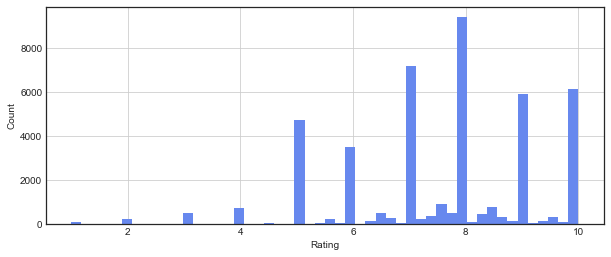

In [126]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=50)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

##### Q2: How does the number of ratings per book distribute?

We can see that most of the books only receive one rating. This makes sence because many books receive only one rating. 

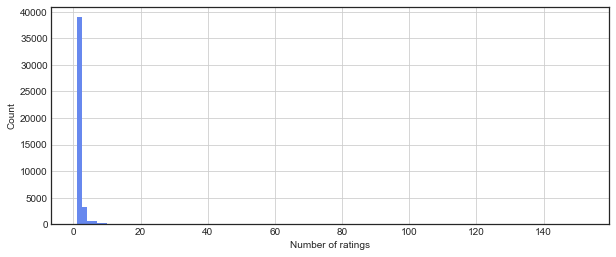

In [127]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=100)
plt.xlabel('Number of ratings')
plt.ylabel('Count')
plt.show()

A jointplot shows how ratings and num of ratings distribute

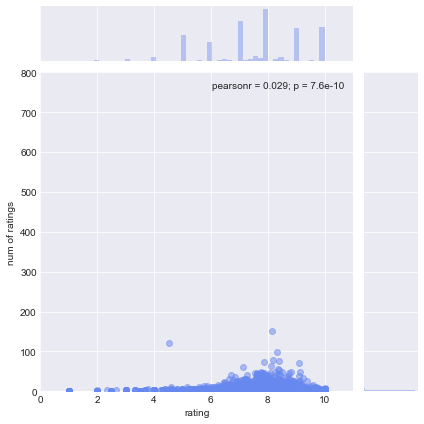

In [128]:
sns.set_style('darkgrid')
sns.set_palette('coolwarm')
sns.jointplot(x='rating',y='num of ratings',data=ratings, alpha=0.5, xlim = (0,11), ylim = (0, 800))

#### Q3: What is the number of ratings per user?

Most of the users only give one rating. The number of ratings per user seems to exponentially decaying. The users who only rate 1 or 2 books do not provide much information on recommending. So I will filter out these users have less than 3 ratings later.

In [129]:
userrating = pd.DataFrame(columns=['num of ratings'])
userrating['rating'] = df.groupby('user_id')['rating'].mean()
userrating['num of ratings'] = df.groupby('user_id')['rating'].count()
userrating.head()

,num of ratings,rating
user_id,,
8,7,5.571429
12,1,10.000000
67,1,7.000000
102,1,7.000000
107,1,8.000000


The maximum number of ratings from one user is: 1180
The minimum number of ratings from one user is: 1


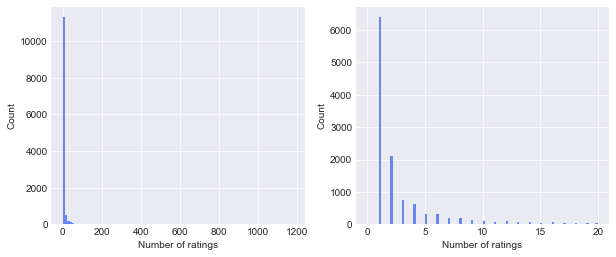

In [130]:
nummax = userrating['num of ratings'].max()
nummin = userrating['num of ratings'].min()
print('The maximum number of ratings from one user is: ' + str(nummax))
print('The minimum number of ratings from one user is: ' + str(nummin))
# Visualize users and their ratings
# Plot the count of number of ratings from all users
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.set_xlabel('Number of ratings')
ax1.set_ylabel('Count')
hist1 = ax1.hist(x = userrating['num of ratings'], bins =100)
ax2.set_xlabel('Number of ratings')
ax2.set_ylabel('Count')
hist2 = ax2.hist(x = userrating['num of ratings'], bins =100, range=(0,20))

#### Q4: Distribution of mean user ratings
Most of the ratings fall between 6 to 9. Still there are peaks at ratings = integer because there are many users who only give one rating. 

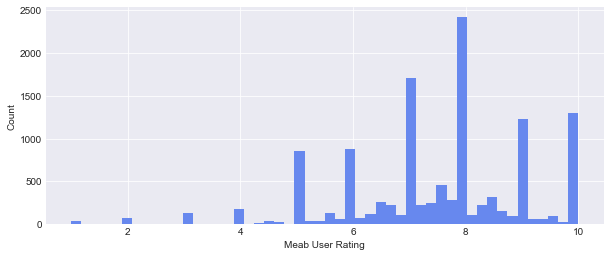

In [131]:
# Visualize the count of ratings from all users.
# It makes sence that there are several peaks which is probably from the many users 
# that only give one rating. 
plt.figure(figsize=(10,4))
plt.xlabel('Meab User Rating')
plt.ylabel('Count')
userrating['rating'].hist(bins=50)

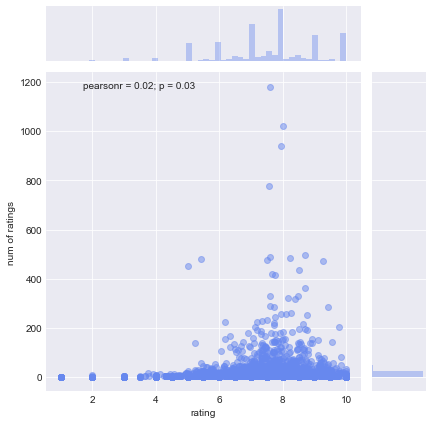

In [132]:
sns.jointplot(x='rating',y='num of ratings',data=userrating,alpha=0.5)

#### Filter out the users with less than 4 rating

People have different tendencies to rate books. Some already give 10 to a mediocre book, while others do not give 10 unless it is the perfect book for them. Such tendencies can be seen in the figure below. On the right side there is a bump from users with a mean rating of 10, indicating that they really liked all books (or they only rated books they really like…). We can also see that there are nearly no notoriuous downvoters rating all books with a 1. Such tendencies are going to be important for collaborative filtering later, and are typically dealt with by subtracting the user’s mean rating from their ratings.

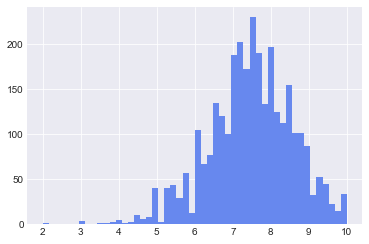

In [133]:
userrating[userrating['num of ratings']>3]['rating'].hist(bins=50)

In [134]:
# Drop rating column
userrating.drop('rating', axis =1, inplace=True)

### Section II:
### Prepare the data for the recommender system

In this section. We further process the data in the following two steps:

1. Filter out the users with less than 4 ratings in df dataframe
2. Map the user id to [0, num_users) and book id to [0, num_books). So that the user id and book is can be directly used as indexes of Rating matrix. Where the rows represent different user and the columns represent different books. 

In [135]:
# From the histograms, we can see that more than 35,000 users in 
# total 68092 users only gives one rating 
userrating['user_id']=userrating.index
df = df.merge(userrating, on = 'user_id')
df.head()

,book_id,implicit,rating,user_id,age,location,num of ratings
0,052165615X,NaN,3,276729,16.0,"rijeka, n/a, croatia",2
1,0521795028,NaN,6,276729,16.0,"rijeka, n/a, croatia",2
2,0747558167,NaN,6,276748,39.0,"jubail ind.-city, eastern province, saudi arabia",2
3,0747558167,NaN,6,276748,39.0,"jubail ind.-city, eastern province, saudi arabia",2
4,0451166892,NaN,5,276755,32.0,"frankfurt am main, hessen, germany",1


In [136]:
# We removed users who rated fewer than 4 books
df = df[df['num of ratings']>3]
df.head()

,book_id,implicit,rating,user_id,age,location,num of ratings
12,3257218516,NaN,3,276866,27.0,"mönchengladbach, nordrhein-westfalen, germany",11
13,3404126343,NaN,8,276866,27.0,"mönchengladbach, nordrhein-westfalen, germany",11
14,3404139178,NaN,9,276866,27.0,"mönchengladbach, nordrhein-westfalen, germany",11
15,3404143299,NaN,7,276866,27.0,"mönchengladbach, nordrhein-westfalen, germany",11
16,340645724X,NaN,3,276866,27.0,"mönchengladbach, nordrhein-westfalen, germany",11


Print the number of books and number of users after filtering

In [137]:
# Get Number of Users and Number of Books in Filtered Data
n_users = df.user_id.nunique()
n_books = df.book_id.nunique()

print('Num. of Users: ' + str(n_users))
print('Num of Books: ' + str(n_books))

Num. of Users: 3069
Num of Books: 39179


##### Sparsity of rating  matrix

The matrix has sparsity > 99%, so very sparse with most entries 0. We need be careful with this when we later do collaboritive filtering. 

In [138]:
# Calculate the sparsity for ratings of books dataset
sparsity = round(1.0-len(df)/float(n_users*n_books), 5)
print('The sparsity level of BooksRecomender Dataset is ' + str(sparsity*100) + '%')

The sparsity level of BooksRecomender Dataset is 99.946%


Map user id from 1 to n_users and map book_id from 1 to n_books

In [139]:
# Map user_id from 1 to n_users
user_index = pd.DataFrame(df['user_id'].unique(), columns=['user_id'])
user_index.sort_values(by='user_id', axis=0, inplace= True)
user_index.reset_index(drop=True, inplace=True)
user_index['user_index']=user_index.index

# Map book_id from 1 to n_books
book_index = pd.DataFrame(df['book_id'].unique(), columns=['book_id'])
book_index.sort_values(by='book_id', axis=0, inplace= True)
book_index.reset_index(drop=True, inplace=True)
book_index['book_index']=book_index.index

Merge the user_id and book_id columns to df dataframe

In [140]:
df = df.merge(user_index, on ='user_id')
df = df.merge(book_index, on = 'book_id')

Print out the first 5 rows of df dataframe

In [141]:
df.head()

,book_id,implicit,rating,user_id,age,location,num of ratings,user_index,book_index
0,3257218516,NaN,3,276866,27.0,"mönchengladbach, nordrhein-westfalen, germany",11,3050,37174
1,3404126343,NaN,8,276866,27.0,"mönchengladbach, nordrhein-westfalen, germany",11,3050,37236
2,3404139178,NaN,9,276866,27.0,"mönchengladbach, nordrhein-westfalen, germany",11,3050,37258
3,3404139178,NaN,10,66483,16.0,"berlin, berlin, germany",53,717,37258
4,3404139178,NaN,9,86583,31.0,"stuttgart, , germany",16,939,37258


##### Q5: What is the top 10 rated books with more than 50 reviews?

Here we only show books with more than 50 views because a book is not necessarily good with a 10 rating if only 1 userrated it. 

It is very interesting that 5 of the top 10 books come from Harry Potter Series. So we may have the trend that if a user likes a series book, he/she may other likes other book in the same series.

In [142]:
# Get the top 10 rated books with more than 50 reviews
ratings['book_id'] = ratings.index
book_ratings = ratings.merge(Books, on='book_id').set_index('title')
book_ratings[book_ratings['num of ratings']>20].sort_values('rating', ascending=False).head(10)

,rating,num of ratings,book_id,author,publisher,year
title,,,,,,
Harry Potter and the Sorcerer's Stone (Book 1),9.384615,26,0590353403,J. K. Rowling,Scholastic,1998
Harry Potter and the Prisoner of Azkaban (Book 3),9.235294,34,0439136350,J. K. Rowling,Scholastic,1999
Harry Potter and the Prisoner of Azkaban (Book 3),9.148148,27,0439136369,J. K. Rowling,Scholastic,2001
To Kill a Mockingbird,9.125000,48,0446310786,Harper Lee,Little Brown &amp; Company,1988
A Wrinkle In Time,9.120000,25,0440498058,MADELEINE L'ENGLE,Yearling,1998
Harry Potter and the Goblet of Fire (Book 4),9.105263,38,0439139597,J. K. Rowling,Scholastic,2000
"The Fellowship of the Ring (The Lord of the Rings, Part 1)",9.090909,22,0345339703,J.R.R. TOLKIEN,Del Rey,1986
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),9.085714,70,059035342X,J. K. Rowling,Arthur A. Levine Books,1999
The Princess Bride: S Morgenstern's Classic Tale of True Love and High Adventure,9.000000,21,0345348036,WILLIAM GOLDMAN,Del Rey,1987


##### Q6: What are the most popular books?

We showed top 10 books that received most ratings. 

In [143]:
# Get the top 10 popular books
book_ratings.sort_values('num of ratings', ascending=False).head(10)

,rating,num of ratings,book_id,author,publisher,year
title,,,,,,
The Lovely Bones: A Novel,8.138158,152,0316666343,Alice Sebold,"Little, Brown",2002
Wild Animus,4.537190,121,0971880107,Rich Shapero,Too Far,2004
The Da Vinci Code,8.343434,99,0385504209,Dan Brown,Doubleday,2003
The Red Tent (Bestselling Backlist),8.179487,78,0312195516,Anita Diamant,Picador USA,1998
The Secret Life of Bees,8.413333,75,0142001740,Sue Monk Kidd,Penguin Books,2003
Divine Secrets of the Ya-Ya Sisterhood: A Novel,7.863014,73,0060928336,Rebecca Wells,Perennial,1997
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),9.085714,70,059035342X,J. K. Rowling,Arthur A. Levine Books,1999
Where the Heart Is (Oprah's Book Club (Paperback)),8.125000,64,0446672211,Billie Letts,Warner Books,1998
A Painted House,7.114754,61,044023722X,John Grisham,Dell Publishing Company,2001


##### Q7: Is there any correlation between number of ratings and the rating of books?

Next, we can see, whether we can find any associations of features with a book’s rating. 

In [144]:
# Is there any correlation between number of ratings 
# and the rating of books
m = np.corrcoef(x=book_ratings['rating'], y=book_ratings['num of ratings'])
print('The correlation between number of ratings and average rating of books is: ' + str(m[0,1]))

The correlation between number of ratings and average rating of books is: 0.0291609400007


We found that the number of ratings of does not affect the rating of books
Hopefully other factors we don't have explicitly are affecting the ratings
i.e. the quality of the book.


#### Section Summary: 

In this section, We identified some interesting aspects of this book datasets. In summary, observed effects on book rating are rather small, suggesting that book rating is mainly driven by other aspects, hopefully including the quality of the book itself.


### Section III:
### Recommender System: Collaborative filtering

Collaboritve filtering is a standard method for product recommendations. We implemented two kinds of collorarive filtering: **Content-based** CF and **Model-based CF**. The main idea of thse two CF are explained below.

1. Content-based CF:

In [163]:
# Change the datatype of ratings to int8 (-128 to 127)
# This has enough bits to hold the rating 0 to 10
# And most importantly, this significantly reduce the RAM needed when 
# calculating matrix multiplication
# subdf['rating'] = subdf['rating'].astype('int8')

In [164]:
#import scipy.sparse as sp
#from scipy.sparse import lil_matrix
#from scipy.sparse import csr_matrix
#from scipy.sparse.linalg import svds

In [165]:
# A model-based Collaborative Filtering system
# Train Test split
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(subdf, test_size=0.25)

#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_books))
for line in train_data.itertuples():
    train_data_matrix[line[6], line[7]] = line[3]  
    
test_data_matrix = np.zeros((n_users, n_books))
for line in test_data.itertuples():
    test_data_matrix[line[6], line[7]] = line[3]

### Make predictions using content based collaboritive filtering


In [167]:
import recommender_system
import imp
imp.reload(recommender_system)
from recommender_system import recommender_system
# Initialize a recommender system
RS = recommender_system();

# Matrix 
user_prediction = np.zeros((n_users, n_books))
# User-item prediction
for i in range(n_users):
    user_prediction[i,:] = RS.predict_content(train_data_matrix, uid = i, d = 5, type='user')
#print('User-based CF RMSE: ' + str(RS.rmse(user_prediction, test_data_matrix)))

In [168]:
#import recommender_system
#import imp
#imp.reload(recommender_system)
#from recommender_system import recommender_system
## Item-item prediction
#item_prediction = np.zeros((n_users, n_books))
#for i in range(n_books):
#    item_prediction[i,:] = RS.predict_content(train_data_matrix, uid = i, type='item')

In [169]:
item_prediction = RS.predict_content(train_data_matrix, type='item')
user_prediction = RS.predict_content(train_data_matrix, type='user')

In [170]:
print('User-based CF RMSE: ' + str(RS.rmse(user_prediction, test_data_matrix)))

User-based CF RMSE: 7.846171197104405


In [171]:
print('Item-based CF RMSE: ' + str(RS.rmse(item_prediction, test_data_matrix)))

Item-based CF RMSE: 7.845135147358469


In [ ]:
# Here is a prediction for spefic users. 
# Here we made predictions for user with uid = 100
from recommender_system import recommender_system
RS = recommender_system();
uid = np.int8(100)
user_pred = RS.predict_content(train_data_matrix, uid = uid, type='user')
item_pred = RS.predict_content(train_data_matrix, uid = uid, type='item')

In [ ]:
print(user_prediction[test_data_matrix.nonzero()].flatten())
print(item_prediction[test_data_matrix.nonzero()].flatten())

In [ ]:
user_pred[test_data_matrix[uid,:].nonzero()]=0
udf = pd.DataFrame(data = user_pred, columns=['pred rating'])

In [ ]:
udf['book_index'] = udf.index

In [ ]:
u100=udf.merge(subdf[['book_index','book_id']], on = 'book_index')

In [ ]:
u100 = u100.drop_duplicates(subset=['book_index'], keep=False)
u100.sort_values(by='pred rating', ascending=False).head(5)

### Make predictions using model based collaboritive filtering

In [ ]:
# The model based collaborative filtering is based on matrix factorization
# It has generally better scalability and sparsity than memory-based CF

In [ ]:
# Calculate the sparsity for ratings of books dataset
sparsity = round(1.0-len(subdf)/float(n_users*n_books), 5)
print('The sparsity level of BooksRecomender Dataset is ' + str(sparsity*100) + '%')

In [ ]:
# A model-based Collaborative Filtering system
# Train Test split
from scipy.sparse import lil_matrix
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(subdf, test_size=0.25)

#Create two user-item matrices, one for training and another for testing
train_data_matrix = lil_matrix((n_users, n_books))
for line in train_data.itertuples():
    train_data_matrix[line[6], line[7]] = line[3]  
    
test_data_matrix = lil_matrix((n_users, n_books))
for line in test_data.itertuples():
    test_data_matrix[line[6], line[7]] = line[3]

In [118]:
from scipy.sparse import lil_matrix
import scipy.sparse as sp
from scipy.sparse.linalg import svds
# Test matrix index
lists = test_data_matrix.nonzero()
u, s, vt = svds(train_data_matrix, k = 100)
s_diag_matrix=np.diag(s)
row = lists[0]
col = lists[1]
pred = np.zeros((n_users, n_books))
for i in range(len(lists[0])):
    pred[row[i], col[i]] = np.dot(np.dot(u[row[i],:], s_diag_matrix), vt[:, col[i]])

In [149]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 200)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE: ' + str(RS.rmse(X_pred, train_data_matrix)))

User-based CF MSE: 6.237562013848951


In [120]:
print('Model -based CF RMSE: ' + str(RS.rmse(pred, test_data_matrix)))

Model -based CF RMSE: 7.7853584045012125


### In the previous model-based CF, we used the rmse as the loss function where we need to minimize on. We can further include a penalty term (i.e. l2 regularization)

